In [24]:
import os
import torch
import torchmetrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# os.environ['CUDA_LAUNCH_BLOCKING']="1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"
data_dir = 'data'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [25]:
df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))
# df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'))
df['tau_ab_ratio'] = df['TAU_bl'] / df['ABETA_bl']
df['ptau_ab_ratio'] = df['PTAU_bl'] / df['ABETA_bl']
df['A+'] = df['ABETA_bl'].apply(lambda x: 1 if x < 880 else 0)
df['T+'] = df['ptau_ab_ratio'].apply(lambda x: 1 if x > 0.028 else 0)
df['N+'] = df['tau_ab_ratio'].apply(lambda x: 1 if x > 0.33 else 0)
# df = df.drop(columns=['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'tau_ab_ratio', 'ptau_ab_ratio',
#                       # 'AGE', 'DX_bl', 'DX', 'FHQMOM',  'FHQMOMAD',  'FHQDAD',  'FHQDADAD', 'RAVLT_perc_forgetting_bl', 'PTGENDER'
#                       ])

# Males vs Females Self and Cross Testing

In [26]:
males_df = df[df['PTGENDER'] == 0]
females_df = df[df['PTGENDER'] == 1]
cols_to_drop = ['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'tau_ab_ratio', 'ptau_ab_ratio']
males_df.drop(columns=['PTGENDER'], inplace=True)

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df['AGE'], bins=30, kde=True)
plt.title('Overall Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

KeyError: 'AGE'

<Figure size 1000x600 with 0 Axes>

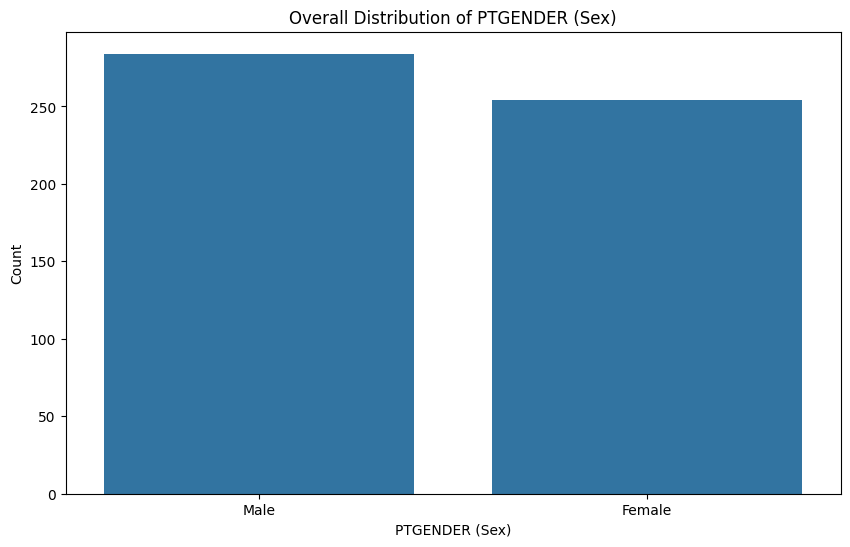

In [235]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='PTGENDER', order=gender_labels.keys())
plt.title('Overall Distribution of PTGENDER (Sex)')
plt.xlabel('PTGENDER (Sex)')
plt.ylabel('Count')
plt.xticks(ticks=list(gender_labels.keys()), labels=list(gender_labels.values()))
plt.show()

In [4]:
class SVM(torch.nn.Module):
    def __init__(self, features, targets):
        super(SVM, self).__init__()
        self.features = features
        self.targets = targets
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()

    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [5]:
index_to_target = {0: 'A+', 1: 'T+', 2: 'N+'}

# STL

## Predict A+

In [6]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['A+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [7]:
# X_train_df = pd.DataFrame(X_train.cpu().numpy(), columns=X.columns)
# # Get the features from df not in X_train_df and extend the columns of X_train_df to include the missing features
# missing_features = set(df.columns) - set(X_train_df.columns)
# for feature in missing_features:
#     # Fill the missing feature with the value from the original DataFrame for the corresponding test samples
#     X_train_df[feature] = df.loc[X_train_df.index, feature].values
#     # Reorder the columns to match the original DataFrame
#     # X_train_df = X_train_df[df.columns]  # Reorder columns to match original DataFrame to untransform

plt.figure(figsize=(10, 6))
sns.countplot(data=X_train_df, x='PTGENDER', order=gender_labels.keys())
plt.title('Distribution of PTGENDER for Training set Samples')
plt.xlabel('PTGENDER')
plt.ylabel('Count')
plt.xticks(ticks=list(gender_labels.keys()), labels=list(gender_labels.values()))
plt.show()

NameError: name 'X_train_df' is not defined

<Figure size 1000x600 with 0 Axes>

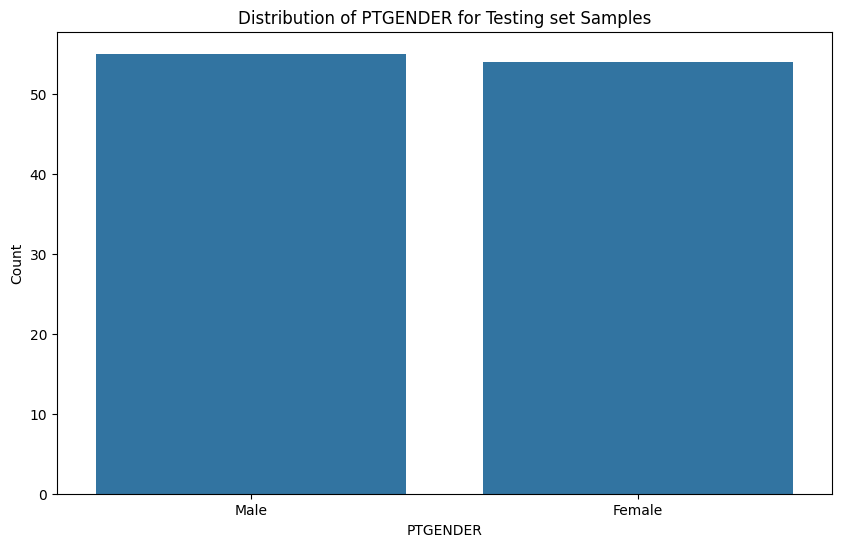

In [237]:
# X_test_df = pd.DataFrame(X_test.cpu().numpy(), columns=X.columns)
# # Get the features from df not in X_test_df and extend the columns of X_test_df to include the missing features
# missing_features = set(df.columns) - set(X_test_df.columns)
# for feature in missing_features:
#     # Fill the missing feature with the value from the original DataFrame for the corresponding test samples
#     X_test_df[feature] = df.loc[X_test_df.index, feature].values
#     # Reorder the columns to match the original DataFrame
#     # X_test_df = X_test_df[df.columns]  # Reorder columns to match original DataFrame to untransform
plt.figure(figsize=(10, 6))
sns.countplot(data=X_test_df, x='PTGENDER', order=gender_labels.keys())
plt.title('Distribution of PTGENDER for Testing set Samples')
plt.xlabel('PTGENDER')
plt.ylabel('Count')
plt.xticks(ticks=list(gender_labels.keys()), labels=list(gender_labels.values()))
plt.show()

In [8]:
model = SVM(X_train, y_train).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.1991
Epoch [2/100], Loss: 1.1854
Epoch [3/100], Loss: 1.1713
Epoch [4/100], Loss: 1.1562
Epoch [5/100], Loss: 1.1415
Epoch [6/100], Loss: 1.1284
Epoch [7/100], Loss: 1.1166
Epoch [8/100], Loss: 1.1046
Epoch [9/100], Loss: 1.0912
Epoch [10/100], Loss: 1.0758
Epoch [11/100], Loss: 1.0599
Epoch [12/100], Loss: 1.0452
Epoch [13/100], Loss: 1.0309
Epoch [14/100], Loss: 1.0151
Epoch [15/100], Loss: 0.9992
Epoch [16/100], Loss: 0.9856
Epoch [17/100], Loss: 0.9738
Epoch [18/100], Loss: 0.9634
Epoch [19/100], Loss: 0.9543
Epoch [20/100], Loss: 0.9449
Epoch [21/100], Loss: 0.9362
Epoch [22/100], Loss: 0.9298
Epoch [23/100], Loss: 0.9242
Epoch [24/100], Loss: 0.9189
Epoch [25/100], Loss: 0.9138
Epoch [26/100], Loss: 0.9089
Epoch [27/100], Loss: 0.9043
Epoch [28/100], Loss: 0.9003
Epoch [29/100], Loss: 0.8967
Epoch [30/100], Loss: 0.8934
Epoch [31/100], Loss: 0.8902
Epoch [32/100], Loss: 0.8871
Epoch [33/100], Loss: 0.8839
Epoch [34/100], Loss: 0.8806
Epoch [35/100], Loss: 0

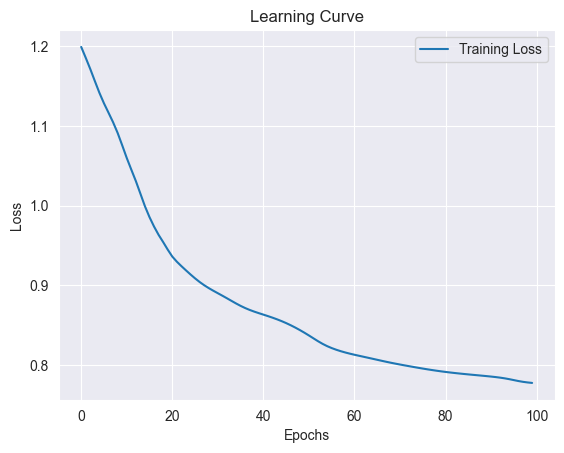

In [9]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [13]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print('ROC AUC:', roc_auc_score(y_train_np, y_pred_np))

    # Identify misclassified data points for each target
    misclassified_indices = {}
    for i in range(y_train_np.shape[1]):
        misclassified = y_train_np[:, i] != y_pred_np[:, i]
        misclassified_indices[index_to_target.get(i)] = np.where(misclassified)[0]

    # Store the misclassified data points in a DataFrame for each target
    misclassified_data = {}
    for target, indices in misclassified_indices.items():
        # Get the misclassified samples from X_test
        misclassified_samples = X_train[indices].cpu().numpy()
        # Create a DataFrame using the column names from the original X DataFrame
        misclassified_data[target] = pd.DataFrame(misclassified_samples, columns=X.columns)

Accuracy: 0.8387096774193549
Precision: 0.8762886597938144
Recall: 0.7870370370370371
F1 Score: 0.8292682926829268
ROC AUC: 0.8384726469588855


In [14]:
# Convert the misclassified DataFrames to a pandas dataframe
misclassified_df = pd.concat(misclassified_data, axis=0).reset_index(drop=True)
misclassified_df.head()

,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,SUVr_ACC_sub_L.nii,SUVr_ACC_sub_R.nii,SUVr_ACC_sup_L.nii,SUVr_ACC_sup_R.nii,SUVr_Amygdala_L.nii,SUVr_Amygdala_R.nii,SUVr_Angular_L.nii,SUVr_Angular_R.nii,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,0.028868,0.132899,0.220847,-0.213623,0.416909,0.644605,-0.137976,0.938962,-0.011698,-0.456012,...,0.930343,1.498458,3.134179,3.326254,2.108219,0.144115,-0.383427,1.138475,1.653030,2.203507
1,0.164103,-0.362648,-0.092404,0.210403,0.132372,-0.209411,-0.843891,-0.847442,-0.107341,-0.411595,...,-0.808839,0.821880,-0.533653,-1.437490,-1.847342,-0.505461,1.994361,-0.334094,-1.115196,-0.940339
2,1.776473,1.935071,1.897110,2.037397,2.998710,2.998420,1.951427,0.523445,2.458879,2.058908,...,3.076380,3.241793,0.808149,-0.786604,0.740730,1.009341,0.616194,3.236908,1.363155,1.469828
3,-0.645332,-0.322116,-0.686128,-0.795641,-0.525117,-0.276722,-0.602873,-0.487695,0.056847,0.561673,...,-0.590606,-1.178963,-0.884293,-0.759929,0.027255,-0.307411,-0.240783,-0.005719,-1.355254,-1.806465
4,-0.295757,-0.387721,-1.126467,-1.190934,-0.443843,-0.435242,-0.838401,-0.834341,-0.613778,-0.661349,...,-0.476569,-0.354920,-0.609490,0.100388,-0.334933,-0.020112,-0.733116,-0.592731,1.070436,0.910231


In [17]:
# Get the features from df not in the misclassified_df and extend the columns of the misclassified_df to include the missing features for the corresponding misclassified samples
missing_features = set(df.columns) - set(misclassified_df.columns)
for feature in missing_features:
    # Fill the missing feature with the value from the original DataFrame for the corresponding misclassified samples
    misclassified_df[feature] = df.loc[misclassified_df.index, feature].values
    # Reorder the columns to match the original DataFrame
misclassified_df = misclassified_df[df.columns]  # Reorder columns to match original DataFrame to untransform
misclassified_df.head()

,TAU_bl,PTAU_bl,ABETA_bl,DX_bl,DX,AGE,PTGENDER,PTEDUCAT,PTRACCAT,MMSE_bl,...,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,tau_ab_ratio,ptau_ab_ratio,A+,T+,N+
0,4.617099,2.310553,731.8,3,2,67.5,0,16,1.0,30.0,...,0.144115,-0.383427,1.138475,1.653030,2.203507,0.006309,0.003157,1,0,0
1,5.783210,3.537766,780.3,3,2,71.8,1,15,0.0,28.0,...,-0.505461,1.994361,-0.334094,-1.115196,-0.940339,0.007412,0.004534,1,1,1
2,6.195221,3.973682,832.7,0,0,78.0,1,12,0.0,24.0,...,1.009341,0.616194,3.236908,1.363155,1.469828,0.007440,0.004772,1,1,1
3,4.683981,2.356126,590.4,3,2,64.9,0,16,0.0,29.0,...,-0.307411,-0.240783,-0.005719,-1.355254,-1.806465,0.007934,0.003991,1,0,0
4,5.509793,3.210037,466.1,3,2,75.1,1,18,0.0,30.0,...,-0.020112,-0.733116,-0.592731,1.070436,0.910231,0.011821,0.006887,1,1,1


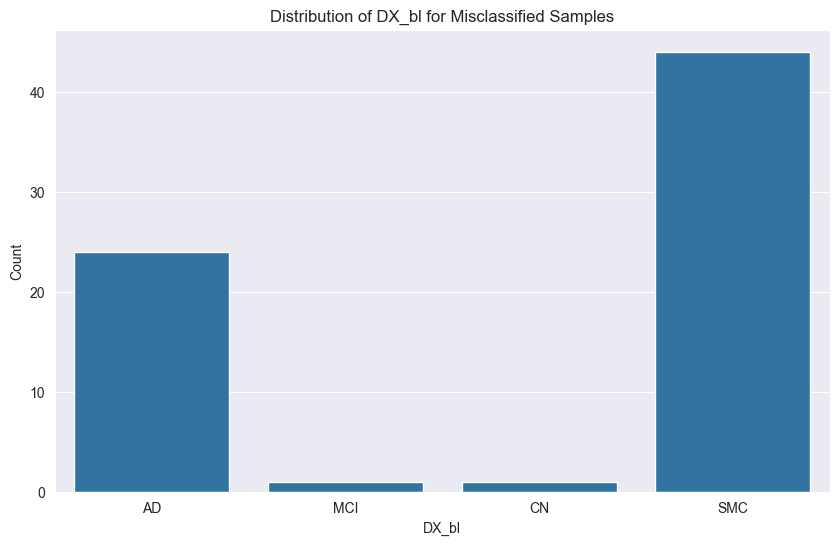

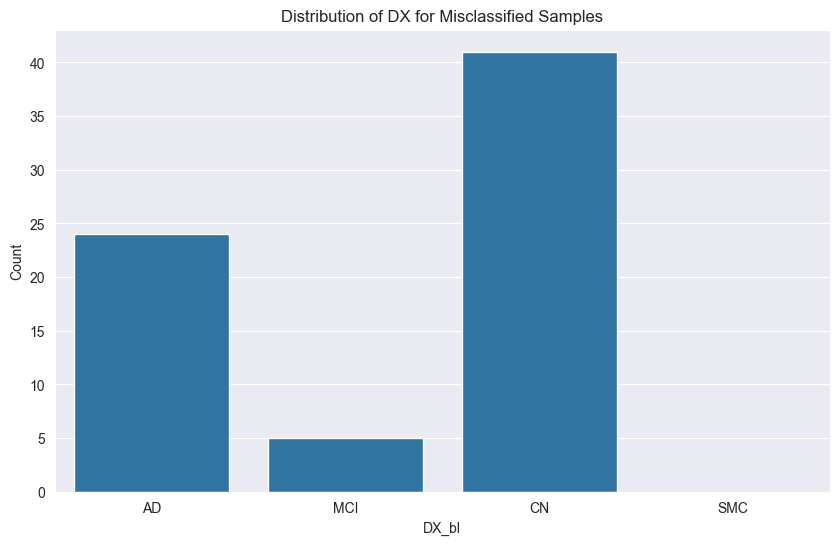

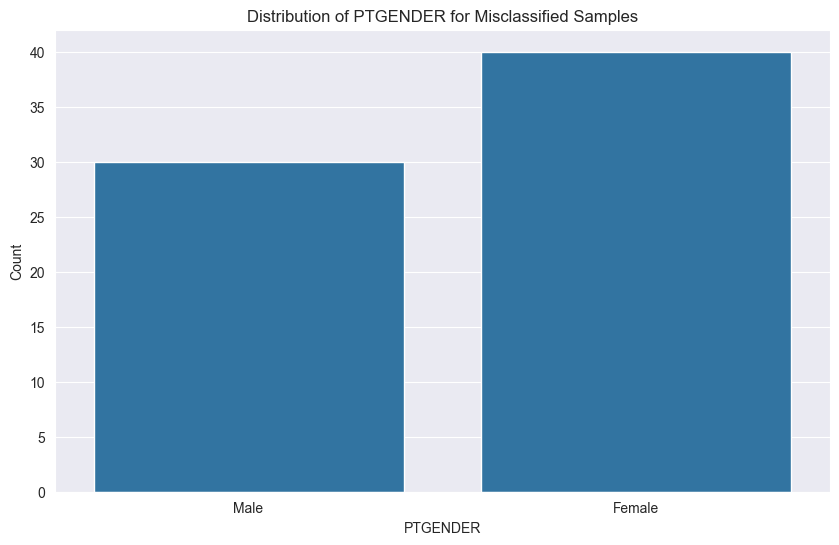

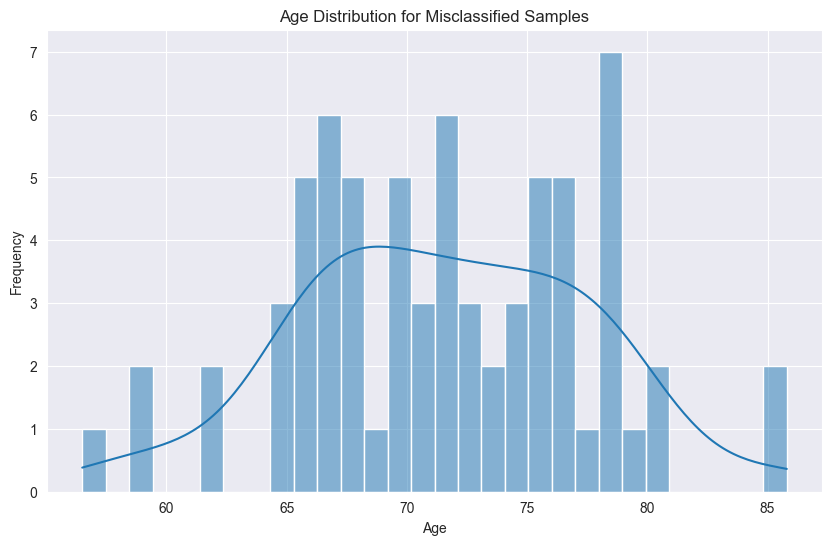

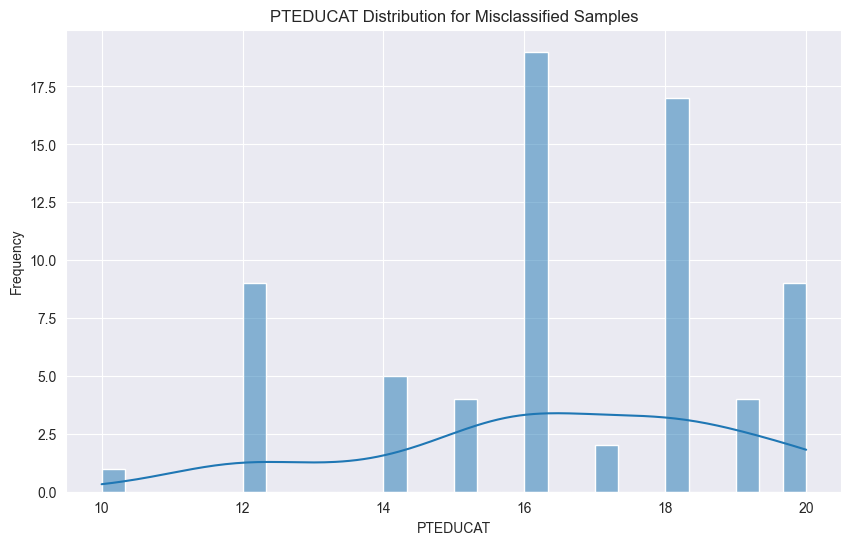

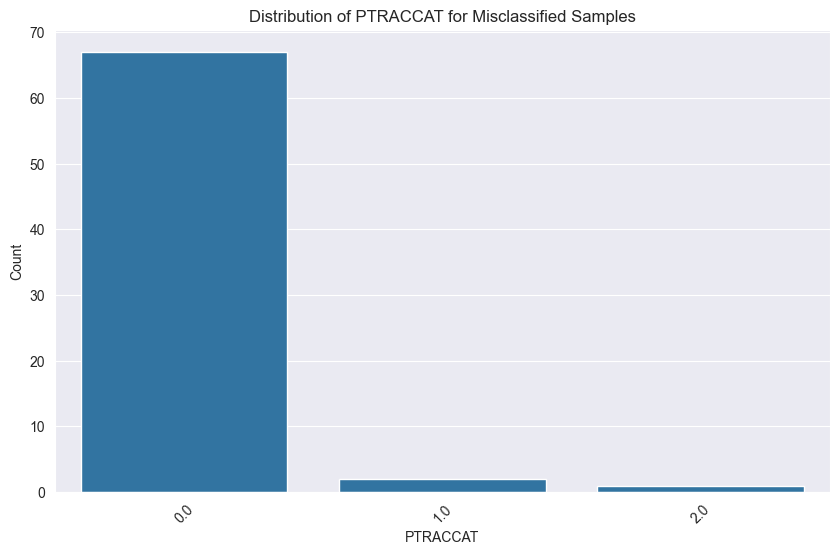

In [18]:
dx_labels = {0: 'AD', 1: 'MCI', 2: 'CN', 3: 'SMC'}
gender_labels = {0: 'Male', 1: 'Female'}

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='DX_bl', order=dx_labels.keys())
plt.title('Distribution of DX_bl for Misclassified Samples')
plt.xlabel('DX_bl')
plt.ylabel('Count')
plt.xticks(ticks=list(dx_labels.keys()), labels=list(dx_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='DX', order=dx_labels.keys())
plt.title('Distribution of DX for Misclassified Samples')
plt.xlabel('DX_bl')
plt.ylabel('Count')
plt.xticks(ticks=list(dx_labels.keys()), labels=list(dx_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='PTGENDER', order=gender_labels.keys())
plt.title('Distribution of PTGENDER for Misclassified Samples')
plt.xlabel('PTGENDER')
plt.ylabel('Count')
plt.xticks(ticks=list(gender_labels.keys()), labels=list(gender_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df['AGE'], bins=30, kde=True)
plt.title('Age Distribution for Misclassified Samples')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df['PTEDUCAT'], bins=30, kde=True)
plt.title('PTEDUCAT Distribution for Misclassified Samples')
plt.xlabel('PTEDUCAT')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of PTRACCAT for misclassified samples
plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='PTRACCAT')
plt.title('Distribution of PTRACCAT for Misclassified Samples')
plt.xlabel('PTRACCAT')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [19]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print('Test ROC AUC:', roc_auc_score(y_test_np, y_test_pred_np))

    # Identify misclassified data points for each target
    misclassified_indices = {}
    for i in range(y_test_np.shape[1]):
        misclassified = y_test_np[:, i] != y_test_pred_np[:, i]
        misclassified_indices[index_to_target.get(i)] = np.where(misclassified)[0]

    # Store the misclassified data points in a DataFrame for each target
    misclassified_data = {}
    for target, indices in misclassified_indices.items():
        # Get the misclassified samples from X_test
        misclassified_samples = X_test[indices].cpu().numpy()
        # Create a DataFrame using the column names from the original X DataFrame
        misclassified_data[target] = pd.DataFrame(misclassified_samples, columns=X.columns)

Test Accuracy: 0.8165137614678899
Test Precision: 0.8478260869565217
Test Recall: 0.75
Test F1 Score: 0.7959183673469389
Test ROC AUC: 0.8135964912280702


In [20]:
# Convert the misclassified DataFrames to a pandas dataframe
misclassified_df = pd.concat(misclassified_data, axis=0).reset_index(drop=True)
misclassified_df.head()

,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,SUVr_ACC_sub_L.nii,SUVr_ACC_sub_R.nii,SUVr_ACC_sup_L.nii,SUVr_ACC_sup_R.nii,SUVr_Amygdala_L.nii,SUVr_Amygdala_R.nii,SUVr_Angular_L.nii,SUVr_Angular_R.nii,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,0.187136,0.149293,-0.214071,-0.021857,-0.256458,-0.104195,0.251669,0.131897,-0.218043,-0.772899,...,0.664276,0.876775,0.815323,0.002687,0.443034,1.376329,0.753551,0.473809,0.582748,0.575454
1,1.179415,1.294424,1.292982,1.161835,1.126971,1.253761,0.274938,0.707366,0.661282,1.072763,...,0.443877,-0.411242,-1.372778,-0.788739,0.244472,-0.542001,-0.183963,0.415675,0.812625,0.648462
2,-0.284462,0.092575,0.348210,0.437109,-0.155328,0.200897,1.057450,0.600154,-0.479821,-0.994641,...,0.596412,0.010962,-0.220765,1.072623,-0.920191,-1.474267,-0.425659,0.165369,0.358824,0.107678
3,0.112586,0.075913,0.472193,0.190058,0.113745,0.386966,-0.062896,-0.191611,0.208590,0.411890,...,-0.437341,-1.613384,-1.381665,-1.312926,-1.228014,-0.794327,-0.446417,-0.156127,0.729944,1.077924
4,-0.023950,-0.067955,-0.187631,-0.115982,-0.368149,-0.318179,0.073049,-0.180545,-0.750608,-0.676860,...,-0.423799,-0.203827,0.753091,0.276056,0.338917,1.080941,1.526982,0.121548,-0.035713,-0.238264


In [141]:
# Get the features from df not in the misclassified_df and extend the columns of the misclassified_df to include the missing features for the corresponding misclassified samples
missing_features = set(df.columns) - set(misclassified_df.columns)
for feature in missing_features:
    # Fill the missing feature with the value from the original DataFrame for the corresponding misclassified samples
    misclassified_df[feature] = df.loc[misclassified_df.index, feature].values
    # Reorder the columns to match the original DataFrame
misclassified_df = misclassified_df[df.columns]  # Reorder columns to match original DataFrame to untransform
misclassified_df.head()

,TAU_bl,PTAU_bl,ABETA_bl,DX_bl,DX,AGE,PTGENDER,PTEDUCAT,PTRACCAT,MMSE_bl,...,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,tau_ab_ratio,ptau_ab_ratio,A+,T+,N+
0,4.617099,2.310553,731.8,3,2,67.5,0,16,-0.226943,30.0,...,0.387527,1.095273,0.543403,-0.545716,-0.656762,0.006309,0.003157,1,0,0
1,5.783210,3.537766,780.3,3,2,71.8,1,15,-0.226943,28.0,...,0.226718,0.122664,0.228140,-0.474249,-0.444203,0.007412,0.004534,1,0,0
2,6.195221,3.973682,832.7,0,0,78.0,1,12,-0.226943,24.0,...,-0.861763,-0.459513,-0.884053,-0.018752,0.220999,0.007440,0.004772,1,0,0
3,4.683981,2.356126,590.4,3,2,64.9,0,16,-0.226943,29.0,...,0.936084,0.370767,-0.858888,-0.477771,-0.059905,0.007934,0.003991,1,0,0
4,5.509793,3.210037,466.1,3,2,75.1,1,18,-0.226943,30.0,...,0.620117,1.815644,1.877145,-1.813452,-1.564836,0.011821,0.006887,1,0,0


In [23]:
dx_labels = {0: 'AD', 1: 'MCI', 2: 'CN', 3: 'SMC'}
gender_labels = {0: 'Male', 1: 'Female'}

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='DX_bl', order=dx_labels.keys())
plt.title('Distribution of DX_bl for Misclassified Samples')
plt.xlabel('DX_bl')
plt.ylabel('Count')
plt.xticks(ticks=list(dx_labels.keys()), labels=list(dx_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='DX', order=dx_labels.keys())
plt.title('Distribution of DX for Misclassified Samples')
plt.xlabel('DX_bl')
plt.ylabel('Count')
plt.xticks(ticks=list(dx_labels.keys()), labels=list(dx_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='PTGENDER', order=gender_labels.keys())
plt.title('Distribution of PTGENDER for Misclassified Samples')
plt.xlabel('PTGENDER')
plt.ylabel('Count')
plt.xticks(ticks=list(gender_labels.keys()), labels=list(gender_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df['AGE'], bins=30, kde=True)
plt.title('Age Distribution for Misclassified Samples')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df['PTEDUCAT'], bins=30, kde=True)
plt.title('PTEDUCAT Distribution for Misclassified Samples')
plt.xlabel('PTEDUCAT')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of PTRACCAT for misclassified samples
plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='PTRACCAT')
plt.title('Distribution of PTRACCAT for Misclassified Samples')
plt.xlabel('PTRACCAT')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

ValueError: Could not interpret value `PTGENDER` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

EcogPtTotal_bl:  log => exp for inverse

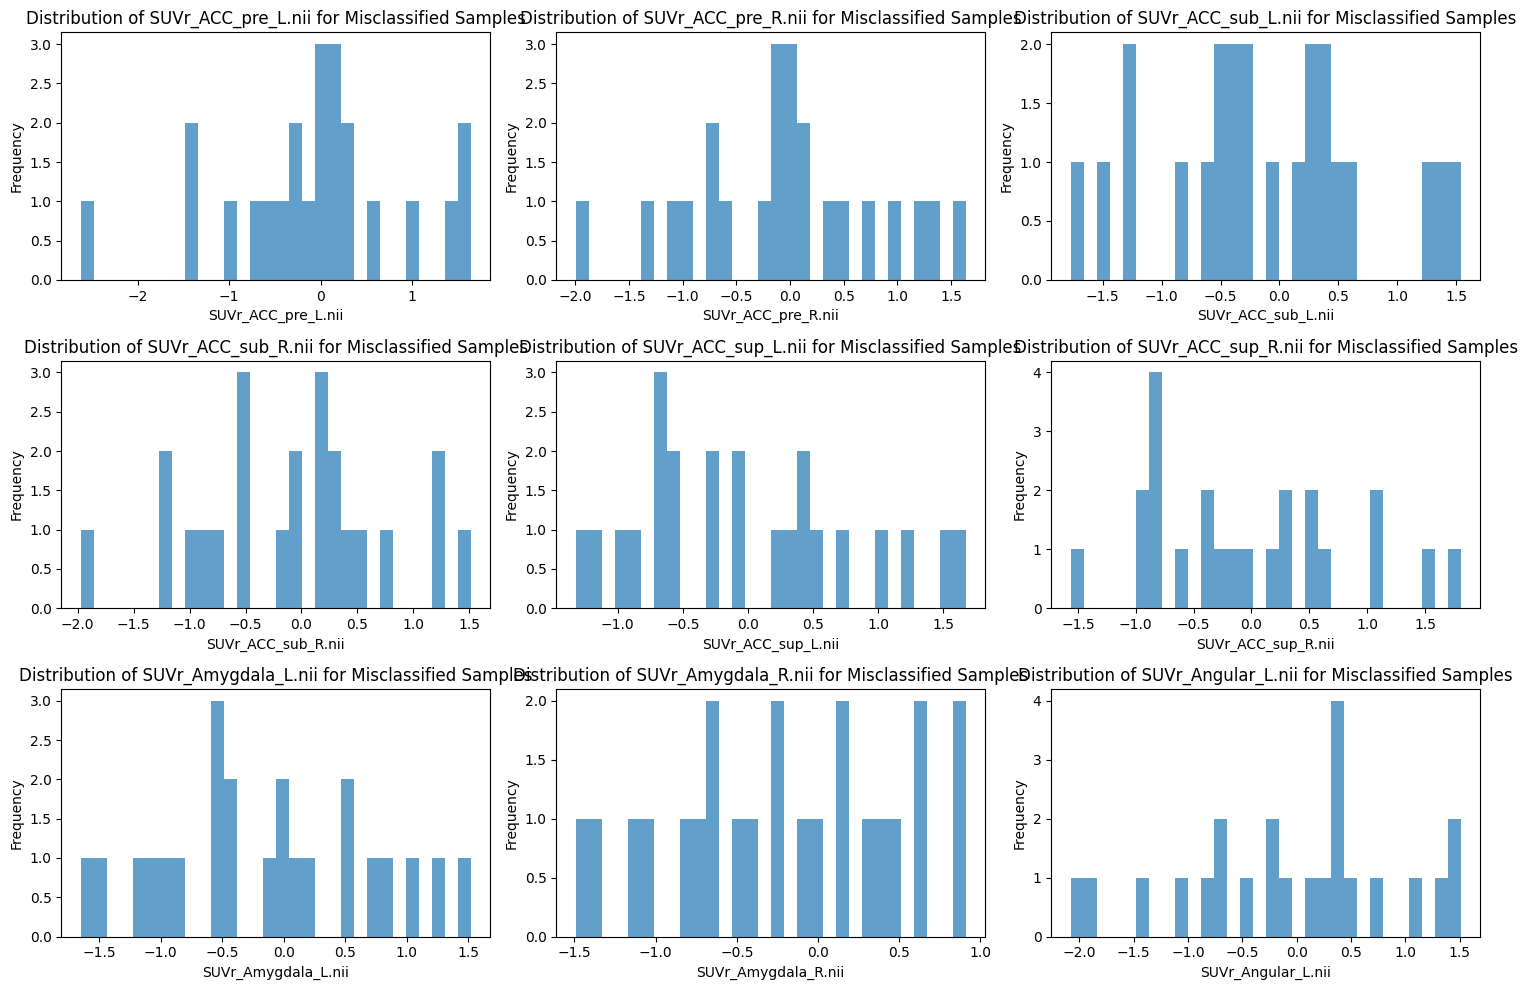

In [112]:
# Plot the distribution of misclassified samples for each feature
plt.figure(figsize=(15, 10))
num_cols = min(9, len(misclassified_df.columns))  # Ensure not more than 9 columns are plotted
for i, column in enumerate(misclassified_df.columns[:num_cols]): # Iterate only through the first num_cols
    plt.subplot(3, 3, i + 1)
    plt.hist(misclassified_df[column], bins=30, alpha=0.7)
    plt.title(f'Distribution of {column} for Misclassified Samples')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Predict T+

In [167]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['T+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [168]:
model = SVM(X_train, y_train, ).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.7888
Epoch [2/100], Loss: 0.7803
Epoch [3/100], Loss: 0.7723
Epoch [4/100], Loss: 0.7655
Epoch [5/100], Loss: 0.7596
Epoch [6/100], Loss: 0.7541
Epoch [7/100], Loss: 0.7489
Epoch [8/100], Loss: 0.7437
Epoch [9/100], Loss: 0.7384
Epoch [10/100], Loss: 0.7336
Epoch [11/100], Loss: 0.7295
Epoch [12/100], Loss: 0.7261
Epoch [13/100], Loss: 0.7231
Epoch [14/100], Loss: 0.7203
Epoch [15/100], Loss: 0.7176
Epoch [16/100], Loss: 0.7151
Epoch [17/100], Loss: 0.7128
Epoch [18/100], Loss: 0.7108
Epoch [19/100], Loss: 0.7090
Epoch [20/100], Loss: 0.7076
Epoch [21/100], Loss: 0.7063
Epoch [22/100], Loss: 0.7053
Epoch [23/100], Loss: 0.7044
Epoch [24/100], Loss: 0.7036
Epoch [25/100], Loss: 0.7029
Epoch [26/100], Loss: 0.7022
Epoch [27/100], Loss: 0.7015
Epoch [28/100], Loss: 0.7008
Epoch [29/100], Loss: 0.7001
Epoch [30/100], Loss: 0.6993
Epoch [31/100], Loss: 0.6984
Epoch [32/100], Loss: 0.6974
Epoch [33/100], Loss: 0.6962
Epoch [34/100], Loss: 0.6949
Epoch [35/100], Loss: 0

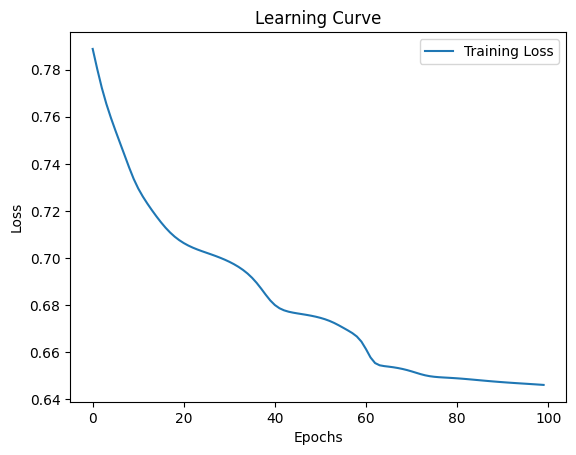

In [169]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [170]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print('ROC AUC:', roc_auc_score(y_train_np, y_pred_np))

Accuracy: 0.9147465437788018
Precision: 0.9405940594059405
Recall: 0.8837209302325582
F1 Score: 0.9112709832134293
ROC AUC: 0.9144632048423065


In [171]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))
    print('Test ROC AUC:', roc_auc_score(y_test_np, y_test_pred_np))

    # Identify misclassified data points for each target
    misclassified_indices = {}
    for i in range(y_test_np.shape[1]):
        misclassified = y_test_np[:, i] != y_test_pred_np[:, i]
        misclassified_indices[index_to_target.get(i)] = np.where(misclassified)[0]

    # Store the misclassified data points in a DataFrame for each target
    misclassified_data = {}
    for target, indices in misclassified_indices.items():
        # Get the misclassified samples from X_test
        misclassified_samples = X_test[indices].cpu().numpy()
        # Create a DataFrame using the column names from the original X DataFrame
        misclassified_data[target] = pd.DataFrame(misclassified_samples, columns=X.columns)

    # Convert the misclassified DataFrames to a pandas dataframe
    misclassified_df = pd.concat(misclassified_data, axis=0).reset_index(drop=True)

Test Accuracy: 0.944954128440367
Test Precision: 0.9761904761904762
Test Recall: 0.8913043478260869
Test F1 Score: 0.9318181818181818
Test ROC AUC: 0.9377156659765357


In [174]:
# Get the features from df not in the misclassified_df and extend the columns of the misclassified_df to include the missing features for the corresponding misclassified samples
missing_features = set(df.columns) - set(misclassified_df.columns)
for feature in missing_features:
    # Fill the missing feature with the value from the original DataFrame for the corresponding misclassified samples
    misclassified_df[feature] = df.loc[misclassified_df.index, feature].values
    # Reorder the columns to match the original DataFrame
misclassified_df = misclassified_df[
    df.columns]  # Reorder columns to match original DataFrame to untransform
misclassified_df.head()

,TAU_bl,PTAU_bl,ABETA_bl,DX_bl,DX,AGE,PTGENDER,PTEDUCAT,PTRACCAT,MMSE_bl,...,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,tau_ab_ratio,ptau_ab_ratio,A+,T+,N+
0,4.617099,2.310553,731.8,3,2,67.5,0,16,1.0,30.0,...,-0.944548,-1.804068,-1.545085,0.452379,0.233688,0.006309,0.003157,1,0,0
1,5.783210,3.537766,780.3,3,2,71.8,1,15,0.0,28.0,...,0.179535,-0.250358,-0.669837,-1.412615,-1.484973,0.007412,0.004534,1,1,1
2,6.195221,3.973682,832.7,0,0,78.0,1,12,0.0,24.0,...,1.318833,0.734367,0.433111,0.626767,0.636302,0.007440,0.004772,1,1,1
3,4.683981,2.356126,590.4,3,2,64.9,0,16,0.0,29.0,...,0.024767,0.056048,0.250018,0.635348,0.950638,0.007934,0.003991,1,0,0
4,5.509793,3.210037,466.1,3,2,75.1,1,18,0.0,30.0,...,-0.555465,-1.066907,-1.165600,-0.290430,-0.124462,0.011821,0.006887,1,1,1


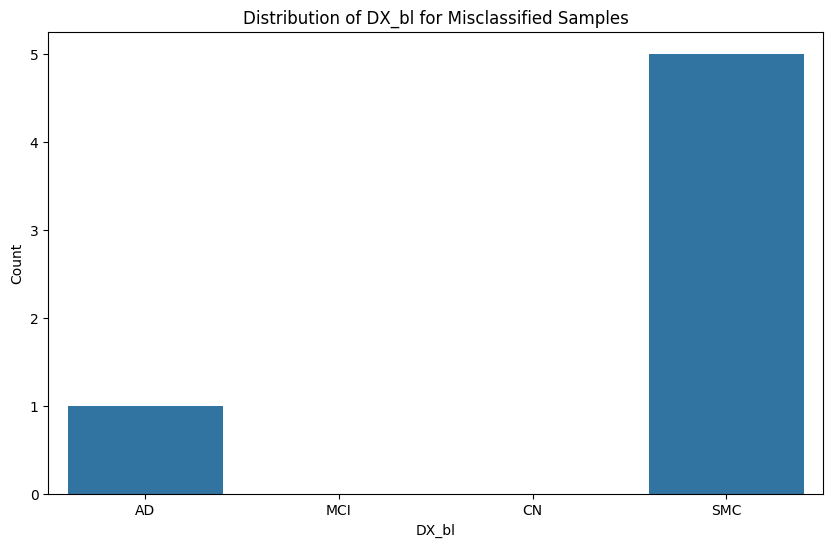

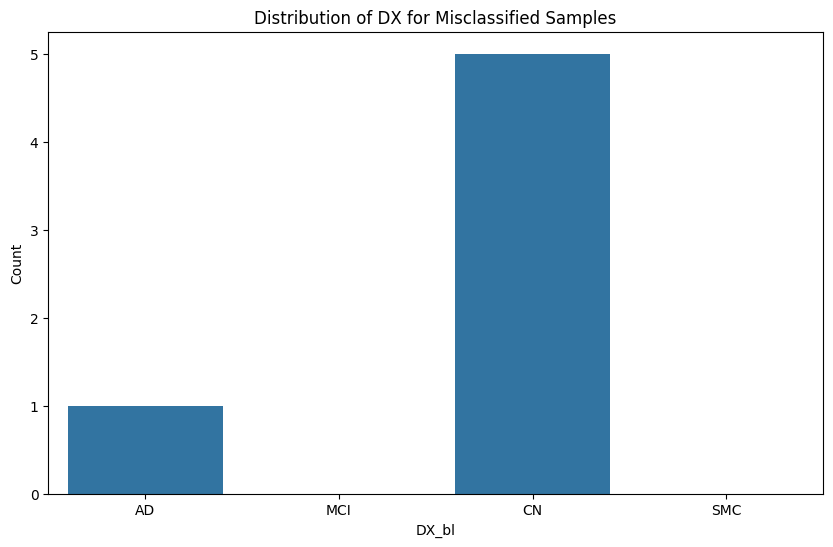

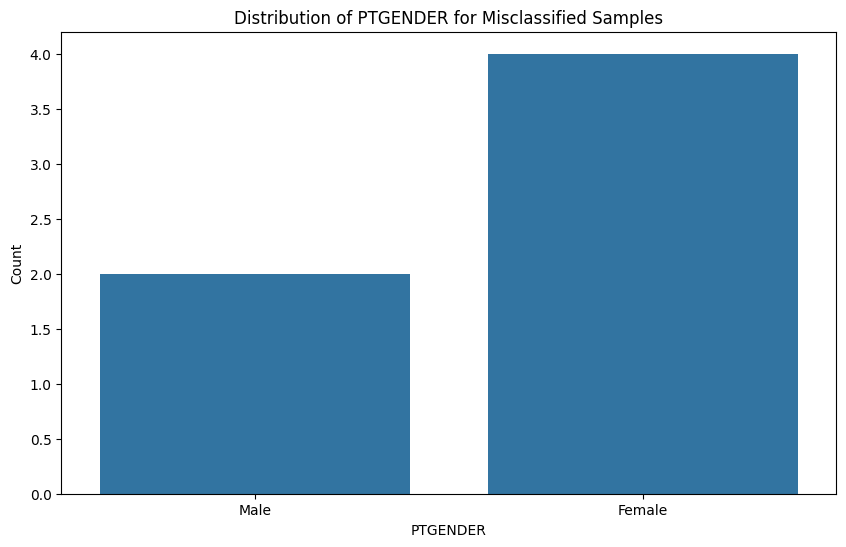

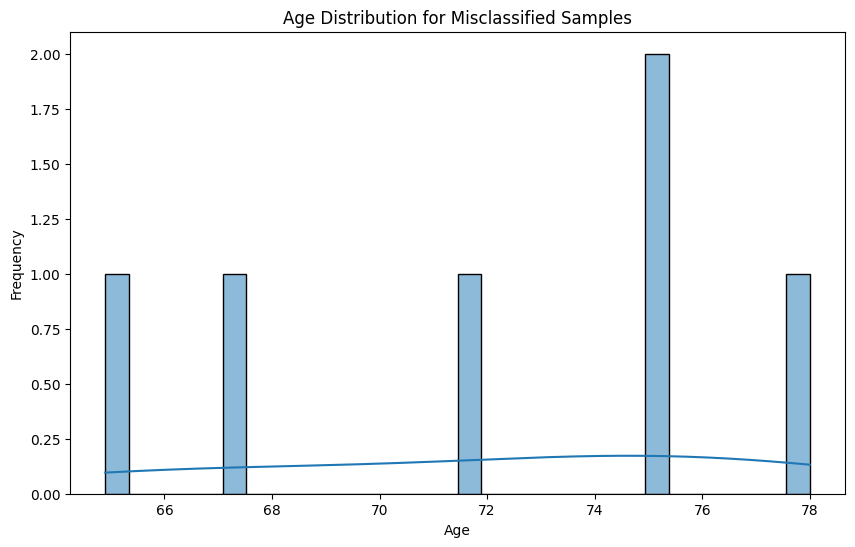

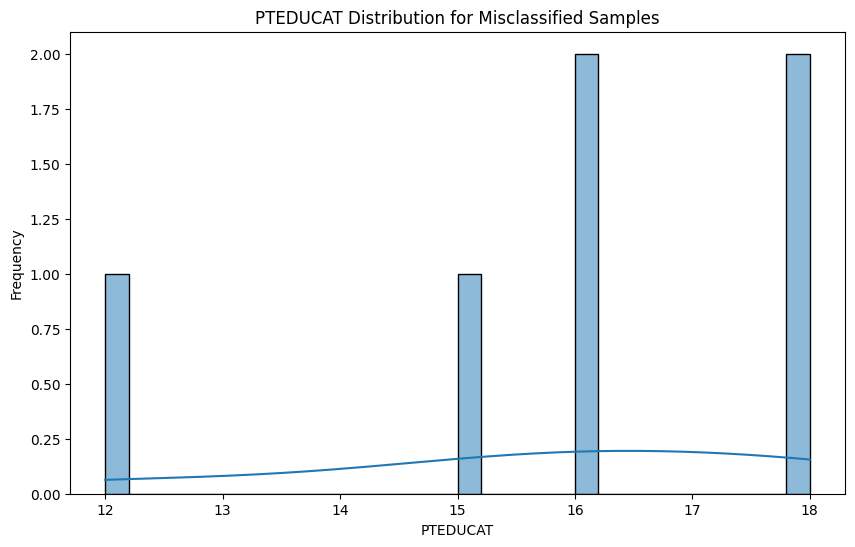

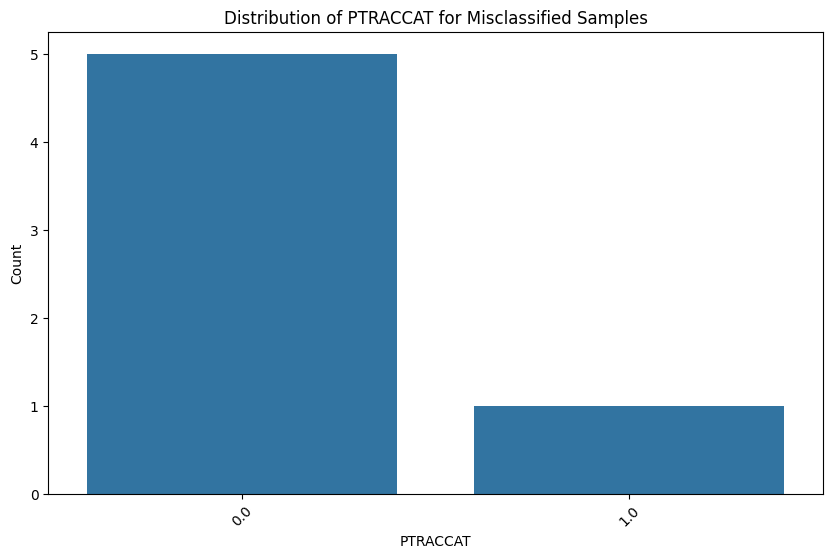

In [175]:
dx_labels = {0: 'AD', 1: 'MCI', 2: 'CN', 3: 'SMC'}
gender_labels = {0: 'Male', 1: 'Female'}

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='DX_bl', order=dx_labels.keys())
plt.title('Distribution of DX_bl for Misclassified Samples')
plt.xlabel('DX_bl')
plt.ylabel('Count')
plt.xticks(ticks=list(dx_labels.keys()), labels=list(dx_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='DX', order=dx_labels.keys())
plt.title('Distribution of DX for Misclassified Samples')
plt.xlabel('DX_bl')
plt.ylabel('Count')
plt.xticks(ticks=list(dx_labels.keys()), labels=list(dx_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='PTGENDER', order=gender_labels.keys())
plt.title('Distribution of PTGENDER for Misclassified Samples')
plt.xlabel('PTGENDER')
plt.ylabel('Count')
plt.xticks(ticks=list(gender_labels.keys()), labels=list(gender_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df['AGE'], bins=30, kde=True)
plt.title('Age Distribution for Misclassified Samples')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df['PTEDUCAT'], bins=30, kde=True)
plt.title('PTEDUCAT Distribution for Misclassified Samples')
plt.xlabel('PTEDUCAT')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of PTRACCAT for misclassified samples
plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='PTRACCAT')
plt.title('Distribution of PTRACCAT for Misclassified Samples')
plt.xlabel('PTRACCAT')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Predict N+

In [177]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['N+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [178]:
model = SVM(X_train, y_train).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.8158
Epoch [2/100], Loss: 1.7693
Epoch [3/100], Loss: 1.7229
Epoch [4/100], Loss: 1.6724
Epoch [5/100], Loss: 1.6278
Epoch [6/100], Loss: 1.5927
Epoch [7/100], Loss: 1.5594
Epoch [8/100], Loss: 1.5237
Epoch [9/100], Loss: 1.4888
Epoch [10/100], Loss: 1.4552
Epoch [11/100], Loss: 1.4203
Epoch [12/100], Loss: 1.3842
Epoch [13/100], Loss: 1.3480
Epoch [14/100], Loss: 1.3128
Epoch [15/100], Loss: 1.2790
Epoch [16/100], Loss: 1.2468
Epoch [17/100], Loss: 1.2150
Epoch [18/100], Loss: 1.1826
Epoch [19/100], Loss: 1.1499
Epoch [20/100], Loss: 1.1180
Epoch [21/100], Loss: 1.0883
Epoch [22/100], Loss: 1.0616
Epoch [23/100], Loss: 1.0361
Epoch [24/100], Loss: 1.0102
Epoch [25/100], Loss: 0.9849
Epoch [26/100], Loss: 0.9617
Epoch [27/100], Loss: 0.9414
Epoch [28/100], Loss: 0.9245
Epoch [29/100], Loss: 0.9110
Epoch [30/100], Loss: 0.9000
Epoch [31/100], Loss: 0.8905
Epoch [32/100], Loss: 0.8821
Epoch [33/100], Loss: 0.8754
Epoch [34/100], Loss: 0.8704
Epoch [35/100], Loss: 0

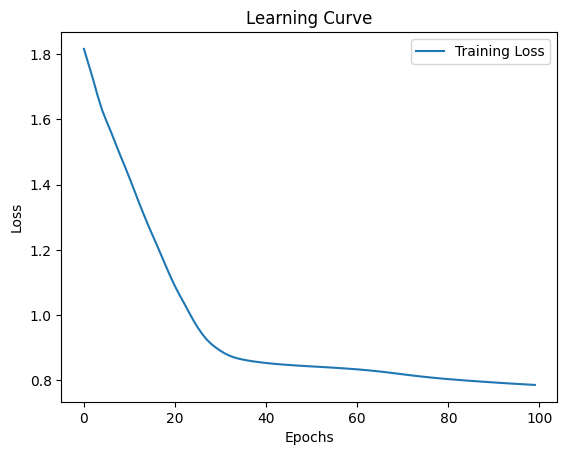

In [179]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [180]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print('ROC AUC:', roc_auc_score(y_train_np, y_pred_np))

Accuracy: 0.8847926267281107
Precision: 0.8564814814814815
Recall: 0.9068627450980392
F1 Score: 0.880952380952381
ROC AUC: 0.8860400682011934


In [181]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))
    print('Test ROC AUC:', roc_auc_score(y_test_np, y_test_pred_np))

    # Identify misclassified data points for each target
    misclassified_indices = {}
    for i in range(y_test_np.shape[1]):
        misclassified = y_test_np[:, i] != y_test_pred_np[:, i]
        misclassified_indices[index_to_target.get(i)] = np.where(misclassified)[0]

    # Store the misclassified data points in a DataFrame for each target
    misclassified_data = {}
    for target, indices in misclassified_indices.items():
        # Get the misclassified samples from X_test
        misclassified_samples = X_test[indices].cpu().numpy()
        # Create a DataFrame using the column names from the original X DataFrame
        misclassified_data[target] = pd.DataFrame(misclassified_samples, columns=X.columns)

    # Convert the misclassified DataFrames to a pandas dataframe
    misclassified_df = pd.concat(misclassified_data, axis=0).reset_index(drop=True)

Test Accuracy: 0.9174311926605505
Test Precision: 0.8775510204081632
Test Recall: 0.9347826086956522
Test F1 Score: 0.9052631578947369
Test ROC AUC: 0.9197722567287785


In [189]:
# Get the features from df not in the misclassified_df and extend the columns of the misclassified_df to include the missing features for the corresponding misclassified samples
missing_features = set(df.columns) - set(misclassified_df.columns)
for feature in missing_features:
    # Fill the missing feature with the value from the original DataFrame for the corresponding misclassified samples
    misclassified_df[feature] = df.loc[misclassified_df.index, feature].values
    # Reorder the columns to match the original DataFrame
misclassified_df = misclassified_df[
    df.columns]  # Reorder columns to match original DataFrame to untransform
misclassified_df.head()

,TAU_bl,PTAU_bl,ABETA_bl,DX_bl,DX,AGE,PTGENDER,PTEDUCAT,PTRACCAT,MMSE_bl,...,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,tau_ab_ratio,ptau_ab_ratio,A+,T+,N+
0,4.617099,2.310553,731.8,3,2,67.5,0,16,1.0,30.0,...,-0.944548,-1.804068,-1.545085,0.452379,0.233688,0.006309,0.003157,1,0,0
1,5.783210,3.537766,780.3,3,2,71.8,1,15,0.0,28.0,...,0.763571,0.972579,0.260951,0.663885,0.528188,0.007412,0.004534,1,0,0
2,6.195221,3.973682,832.7,0,0,78.0,1,12,0.0,24.0,...,1.318833,0.734367,0.433111,0.626767,0.636302,0.007440,0.004772,1,0,0
3,4.683981,2.356126,590.4,3,2,64.9,0,16,0.0,29.0,...,-0.135252,-0.561159,-0.335412,0.314564,0.241390,0.007934,0.003991,1,0,0
4,5.509793,3.210037,466.1,3,2,75.1,1,18,0.0,30.0,...,0.048595,-0.585824,-0.033518,0.252288,0.691143,0.011821,0.006887,1,0,0


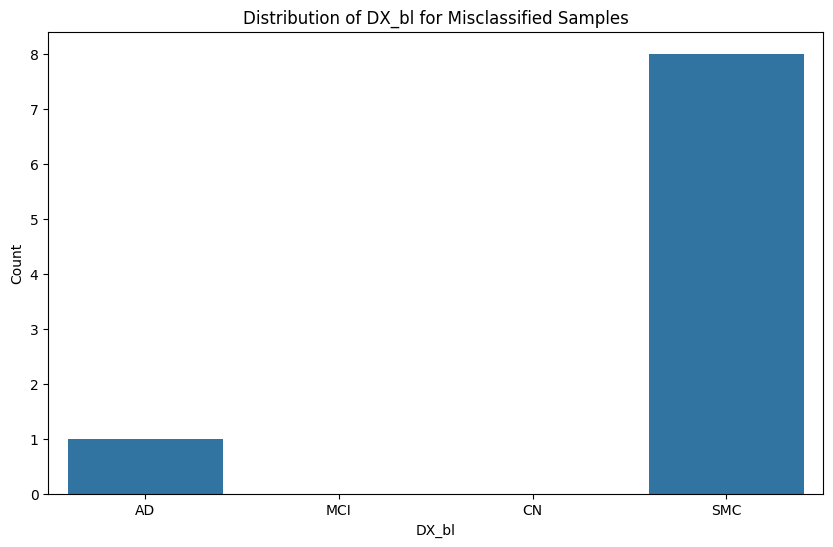

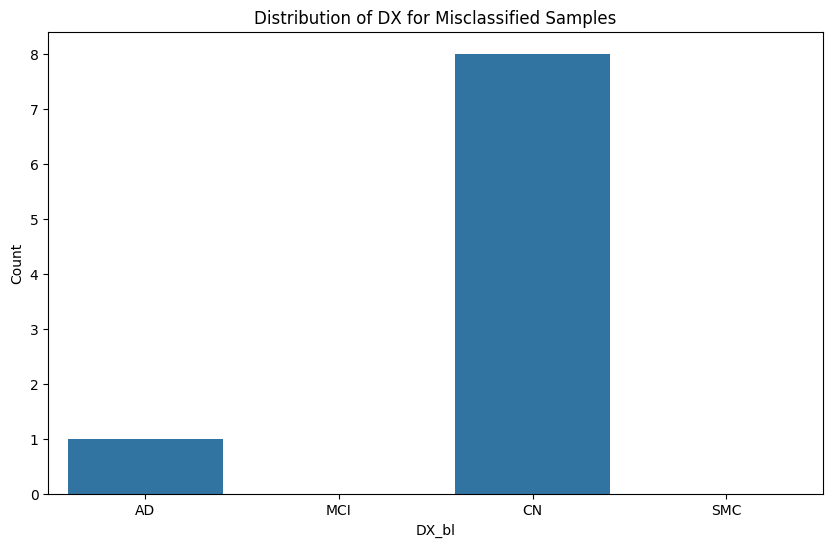

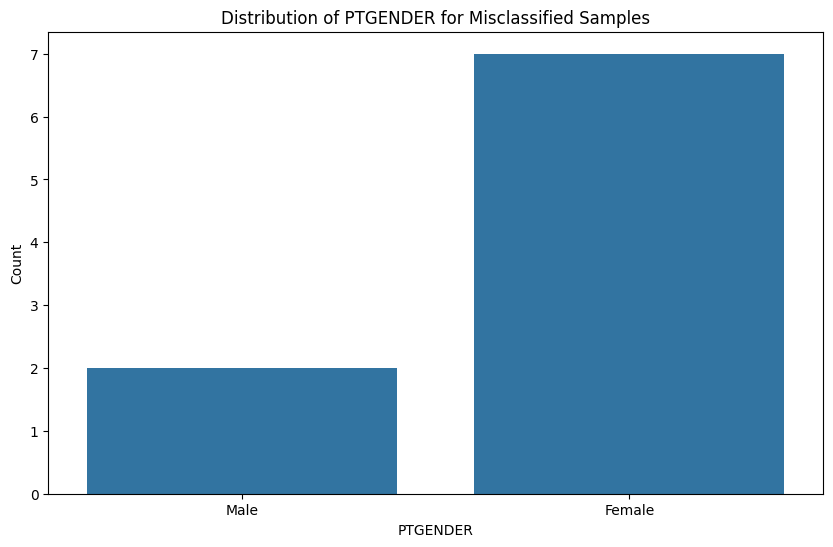

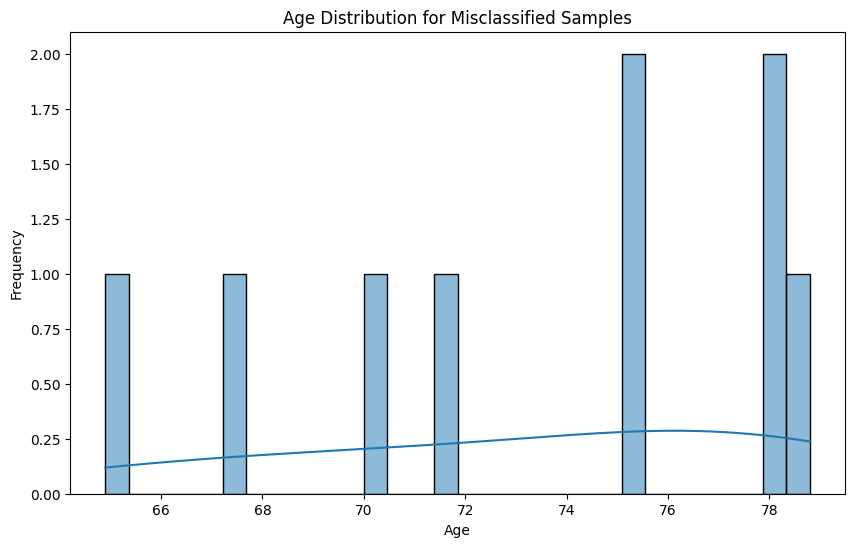

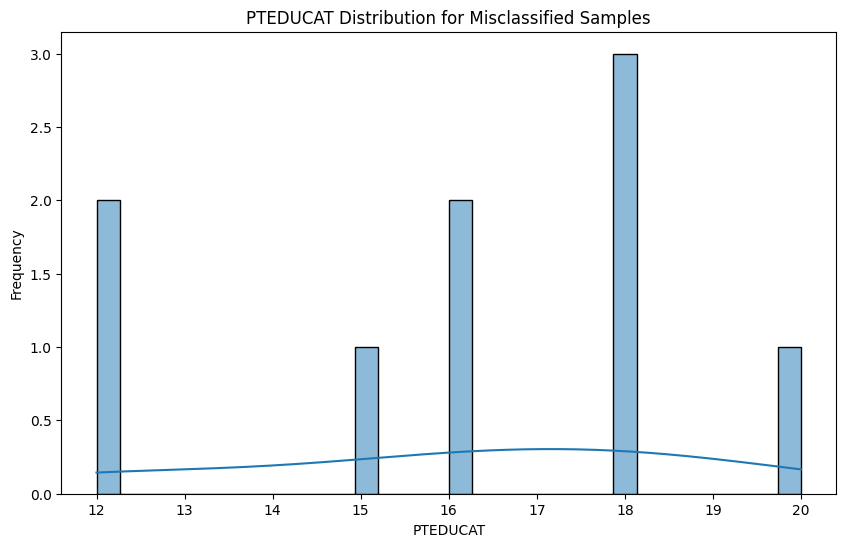

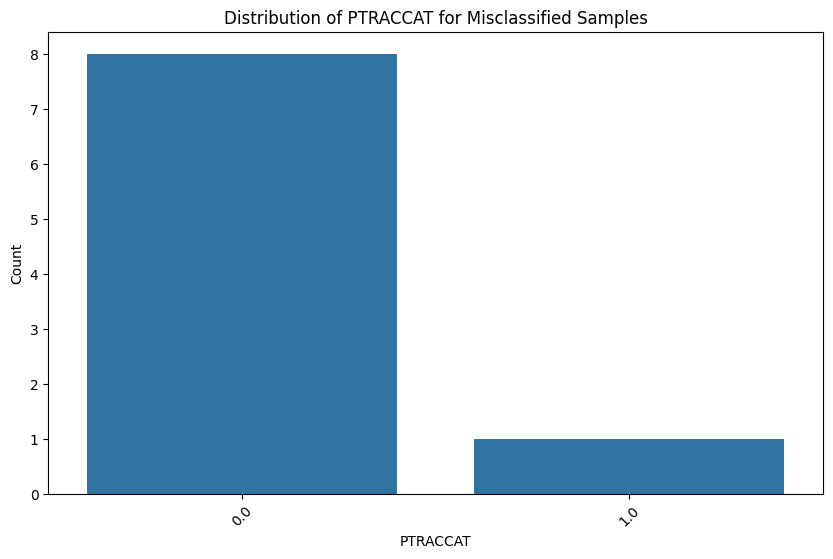

In [190]:
dx_labels = {0: 'AD', 1: 'MCI', 2: 'CN', 3: 'SMC'}
gender_labels = {0: 'Male', 1: 'Female'}

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='DX_bl', order=dx_labels.keys())
plt.title('Distribution of DX_bl for Misclassified Samples')
plt.xlabel('DX_bl')
plt.ylabel('Count')
plt.xticks(ticks=list(dx_labels.keys()), labels=list(dx_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='DX', order=dx_labels.keys())
plt.title('Distribution of DX for Misclassified Samples')
plt.xlabel('DX_bl')
plt.ylabel('Count')
plt.xticks(ticks=list(dx_labels.keys()), labels=list(dx_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='PTGENDER', order=gender_labels.keys())
plt.title('Distribution of PTGENDER for Misclassified Samples')
plt.xlabel('PTGENDER')
plt.ylabel('Count')
plt.xticks(ticks=list(gender_labels.keys()), labels=list(gender_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df['AGE'], bins=30, kde=True)
plt.title('Age Distribution for Misclassified Samples')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df['PTEDUCAT'], bins=30, kde=True)
plt.title('PTEDUCAT Distribution for Misclassified Samples')
plt.xlabel('PTEDUCAT')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of PTRACCAT for misclassified samples
plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='PTRACCAT')
plt.title('Distribution of PTRACCAT for Misclassified Samples')
plt.xlabel('PTRACCAT')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# MTL

In [192]:
class MultitaskSVM(torch.nn.Module):
    def __init__(self, features, targets):
        super(MultitaskSVM, self).__init__()
        self.features = features
        self.targets = targets
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 3), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()

    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [193]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df.filter(['A+', 'T+', 'N+'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [194]:
model = MultitaskSVM(X_train, y_train).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.4459
Epoch [2/100], Loss: 1.3971
Epoch [3/100], Loss: 1.3505
Epoch [4/100], Loss: 1.3082
Epoch [5/100], Loss: 1.2682
Epoch [6/100], Loss: 1.2309
Epoch [7/100], Loss: 1.1981
Epoch [8/100], Loss: 1.1681
Epoch [9/100], Loss: 1.1377
Epoch [10/100], Loss: 1.1057
Epoch [11/100], Loss: 1.0741
Epoch [12/100], Loss: 1.0459
Epoch [13/100], Loss: 1.0203
Epoch [14/100], Loss: 0.9960
Epoch [15/100], Loss: 0.9716
Epoch [16/100], Loss: 0.9515
Epoch [17/100], Loss: 0.9307
Epoch [18/100], Loss: 0.9079
Epoch [19/100], Loss: 0.8852
Epoch [20/100], Loss: 0.8661
Epoch [21/100], Loss: 0.8512
Epoch [22/100], Loss: 0.8402
Epoch [23/100], Loss: 0.8325
Epoch [24/100], Loss: 0.8267
Epoch [25/100], Loss: 0.8214
Epoch [26/100], Loss: 0.8164
Epoch [27/100], Loss: 0.8117
Epoch [28/100], Loss: 0.8078
Epoch [29/100], Loss: 0.8047
Epoch [30/100], Loss: 0.8019
Epoch [31/100], Loss: 0.7991
Epoch [32/100], Loss: 0.7962
Epoch [33/100], Loss: 0.7932
Epoch [34/100], Loss: 0.7901
Epoch [35/100], Loss: 0

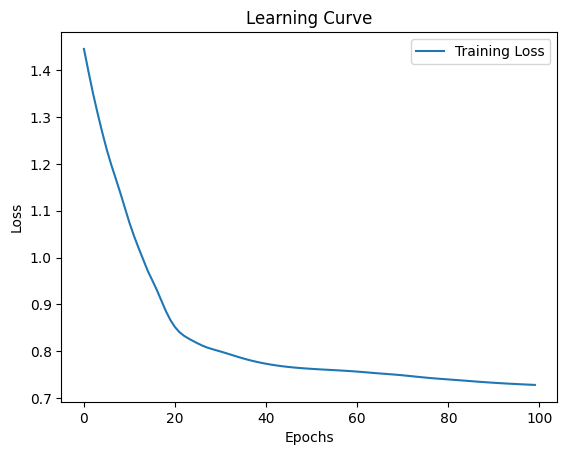

In [195]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [197]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()

    for i in range(y_train_np.shape[1]):
        print(f"Metrics for target {index_to_target.get(i)}:")
        print("Accuracy:", accuracy_score(y_train_np[:, i], y_pred_np[:, i]))
        print("Precision:", precision_score(y_train_np[:, i], y_pred_np[:, i]))
        print("Recall:", recall_score(y_train_np[:, i], y_pred_np[:, i]))
        precision = precision_score(y_train_np[:, i], y_pred_np[:, i])
        recall = recall_score(y_train_np[:, i], y_pred_np[:, i])
        print("F1 Score:", 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0)
        print('ROC AUC:', roc_auc_score(y_train_np[:, i], y_pred_np[:, i]))
        print()


Metrics for target A+:
Accuracy: 0.847926267281106
Precision: 0.8774509803921569
Recall: 0.8136363636363636
F1 Score: 0.8443396226415094
ROC AUC: 0.8484069668649108

Metrics for target T+:
Accuracy: 0.9009216589861752
Precision: 0.93
Recall: 0.8651162790697674
F1 Score: 0.8963855421686747
ROC AUC: 0.900594669215249

Metrics for target N+:
Accuracy: 0.8940092165898618
Precision: 0.883495145631068
Recall: 0.8921568627450981
F1 Score: 0.8878048780487806
ROC AUC: 0.8939045183290708



In [198]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # For multitask (MTL) evaluation, print metrics for each target
    for i in range(y_test_np.shape[1]):
        print(f"Test Metrics for target {index_to_target.get(i)}:")
        print("Test Accuracy:", accuracy_score(y_test_np[:, i], y_test_pred_np[:, i]))
        print("Test Precision:", precision_score(y_test_np[:, i], y_test_pred_np[:, i]))
        print("Test Recall:", recall_score(y_test_np[:, i], y_test_pred_np[:, i]))
        precision = precision_score(y_test_np[:, i], y_test_pred_np[:, i])
        recall = recall_score(y_test_np[:, i], y_test_pred_np[:, i])
        print("Test F1 Score:", 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0)
        print('Test ROC AUC:', roc_auc_score(y_test_np[:, i], y_test_pred_np[:, i]))
        print()

        # Identify misclassified data points for each target
        misclassified_indices = {}
        for i in range(y_test_np.shape[1]):
            misclassified = y_test_np[:, i] != y_test_pred_np[:, i]
            misclassified_indices[index_to_target.get(i)] = np.where(misclassified)[0]

        # Store the misclassified data points in a DataFrame for each target
        misclassified_data = {}
        for target, indices in misclassified_indices.items():
            # Get the misclassified samples from X_test
            misclassified_samples = X_test[indices].cpu().numpy()
            # Create a DataFrame using the column names from the original X DataFrame
            misclassified_data[target] = pd.DataFrame(misclassified_samples, columns=X.columns)

        # Convert the misclassified DataFrames to a pandas dataframe
        misclassified_df = pd.concat(misclassified_data, axis=0).reset_index(drop=True)

Test Metrics for target A+:
Test Accuracy: 0.7981651376146789
Test Precision: 0.7954545454545454
Test Recall: 0.7291666666666666
Test F1 Score: 0.7608695652173914
Test ROC AUC: 0.7908128415300546

Test Metrics for target T+:
Test Accuracy: 0.944954128440367
Test Precision: 0.9347826086956522
Test Recall: 0.9347826086956522
Test F1 Score: 0.9347826086956522
Test ROC AUC: 0.9435817805383023

Test Metrics for target N+:
Test Accuracy: 0.926605504587156
Test Precision: 0.9318181818181818
Test Recall: 0.8913043478260869
Test F1 Score: 0.9111111111111111
Test ROC AUC: 0.9218426501035196



In [200]:
# Get the features from df not in the misclassified_df and extend the columns of the misclassified_df to include the missing features for the corresponding misclassified samples
missing_features = set(df.columns) - set(misclassified_df.columns)
for feature in missing_features:
    # Fill the missing feature with the value from the original DataFrame for the corresponding misclassified samples
    misclassified_df[feature] = df.loc[misclassified_df.index, feature].values
    # Reorder the columns to match the original DataFrame
misclassified_df = misclassified_df[
    df.columns]  # Reorder columns to match original DataFrame to untransform
misclassified_df.head()

,TAU_bl,PTAU_bl,ABETA_bl,DX_bl,DX,AGE,PTGENDER,PTEDUCAT,PTRACCAT,MMSE_bl,...,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,tau_ab_ratio,ptau_ab_ratio,A+,T+,N+
0,4.617099,2.310553,731.8,3,2,67.5,0,16,1.0,30.0,...,0.104015,-0.304258,-0.761948,-1.605480,-1.457692,0.006309,0.003157,1,0,0
1,5.783210,3.537766,780.3,3,2,71.8,1,15,0.0,28.0,...,0.391105,1.059482,0.494104,-0.518924,-0.636702,0.007412,0.004534,1,0,0
2,6.195221,3.973682,832.7,0,0,78.0,1,12,0.0,24.0,...,-0.851237,-0.471832,-0.885006,-0.001375,0.236565,0.007440,0.004772,1,0,0
3,4.683981,2.356126,590.4,3,2,64.9,0,16,0.0,29.0,...,0.763571,0.972579,0.260951,0.663885,0.528188,0.007934,0.003991,1,0,0
4,5.509793,3.210037,466.1,3,2,75.1,1,18,0.0,30.0,...,0.398088,1.539177,1.356627,0.093564,-0.219827,0.011821,0.006887,1,0,0


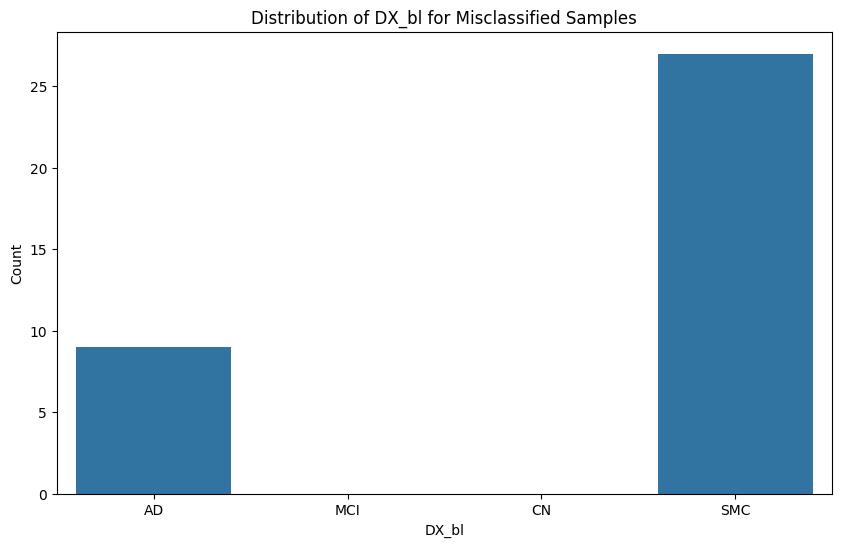

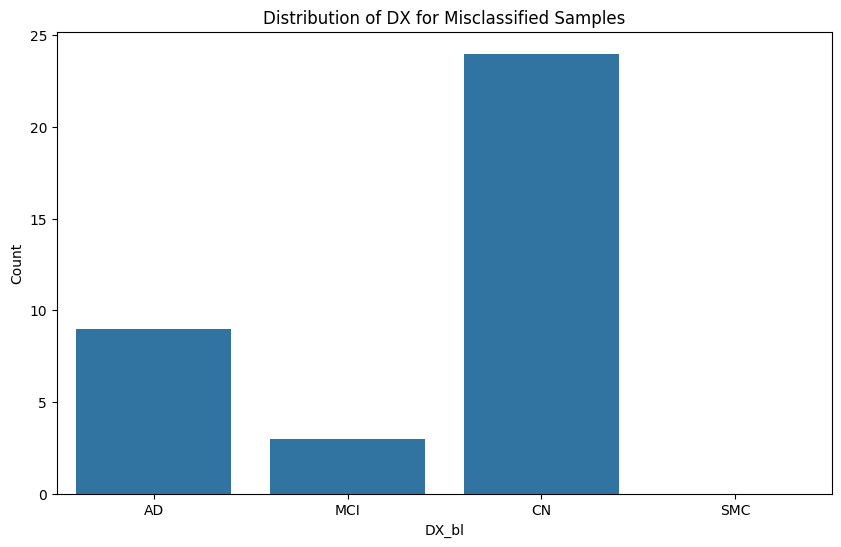

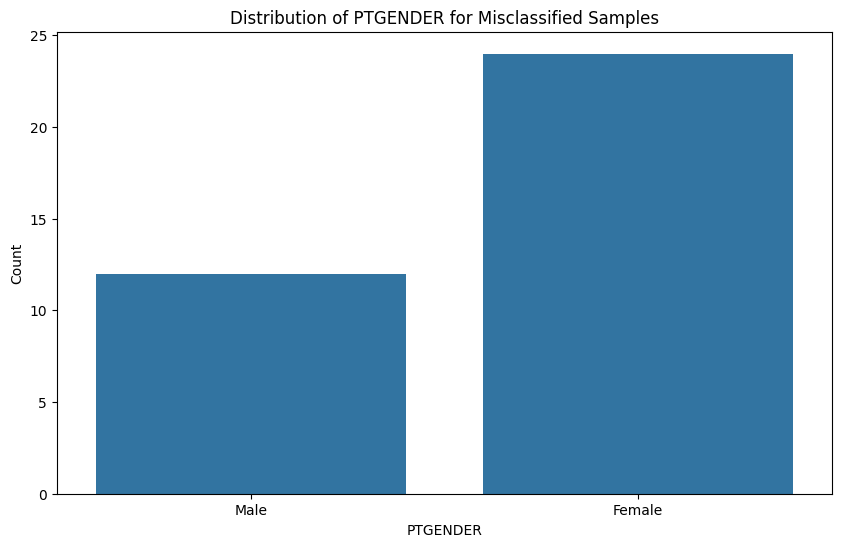

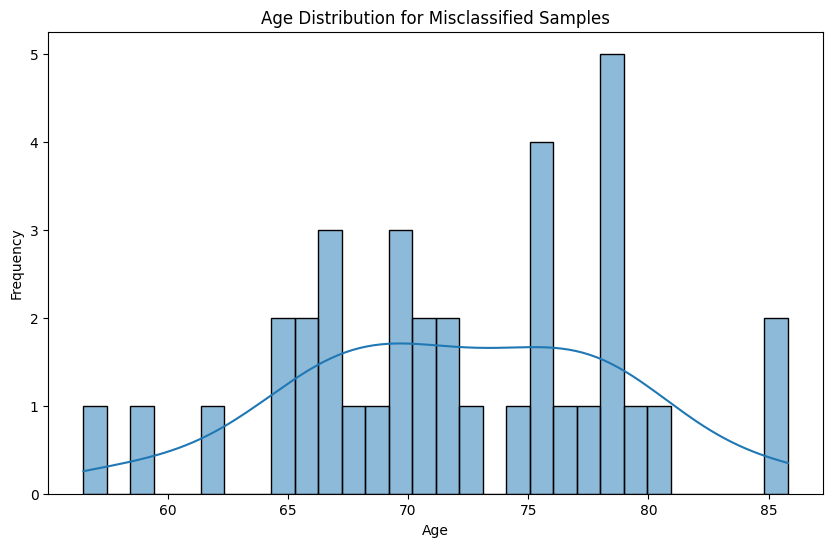

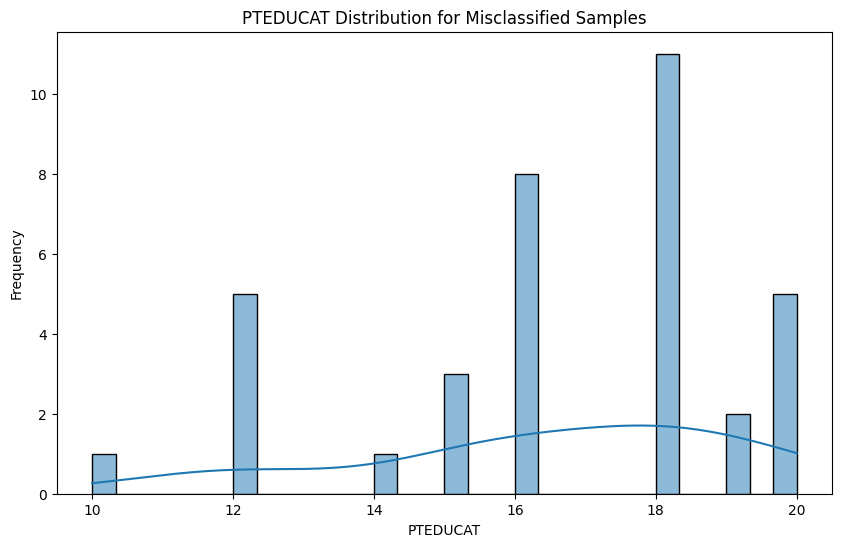

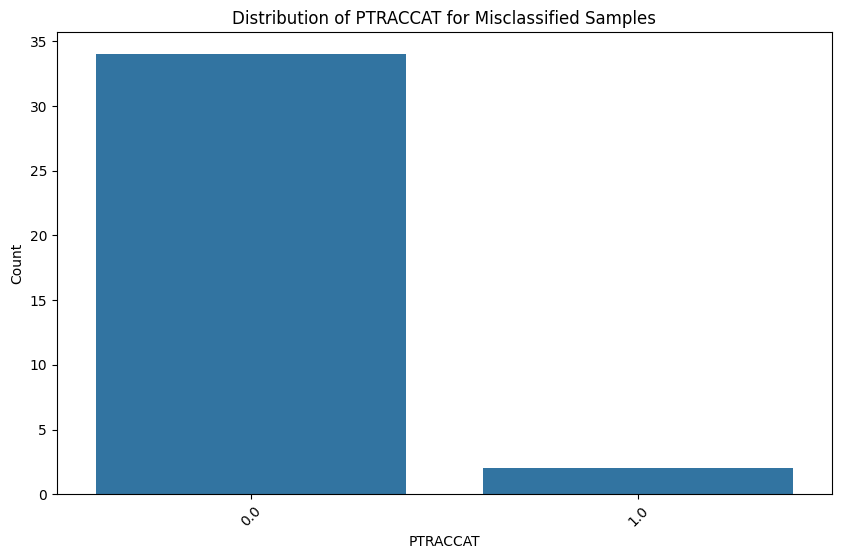

In [201]:
dx_labels = {0: 'AD', 1: 'MCI', 2: 'CN', 3: 'SMC'}
gender_labels = {0: 'Male', 1: 'Female'}

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='DX_bl', order=dx_labels.keys())
plt.title('Distribution of DX_bl for Misclassified Samples')
plt.xlabel('DX_bl')
plt.ylabel('Count')
plt.xticks(ticks=list(dx_labels.keys()), labels=list(dx_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='DX', order=dx_labels.keys())
plt.title('Distribution of DX for Misclassified Samples')
plt.xlabel('DX_bl')
plt.ylabel('Count')
plt.xticks(ticks=list(dx_labels.keys()), labels=list(dx_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='PTGENDER', order=gender_labels.keys())
plt.title('Distribution of PTGENDER for Misclassified Samples')
plt.xlabel('PTGENDER')
plt.ylabel('Count')
plt.xticks(ticks=list(gender_labels.keys()), labels=list(gender_labels.values()))
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df['AGE'], bins=30, kde=True)
plt.title('Age Distribution for Misclassified Samples')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df['PTEDUCAT'], bins=30, kde=True)
plt.title('PTEDUCAT Distribution for Misclassified Samples')
plt.xlabel('PTEDUCAT')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of PTRACCAT for misclassified samples
plt.figure(figsize=(10, 6))
sns.countplot(data=misclassified_df, x='PTRACCAT')
plt.title('Distribution of PTRACCAT for Misclassified Samples')
plt.xlabel('PTRACCAT')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()